In [1]:
import torch
import torch.functional as F
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from torchviz import make_dot
from IPython.display import HTML
from tqdm import tqdm
%matplotlib inline

In [2]:
# strength and range parameter of potential
eps,sig = 1.0,1.5

In [3]:
def Ulj(rs):
    f6 = (sig / rs) ** 6
    return 4*eps*(f6*f6  - f6)

In [4]:
base = torch.linspace(0.0, 4*sig,1000, requires_grad=True)
xs = base / sig
ps = Ulj(xs)/eps
loss = ps.sum()
loss.backward()
dps = base.grad / eps

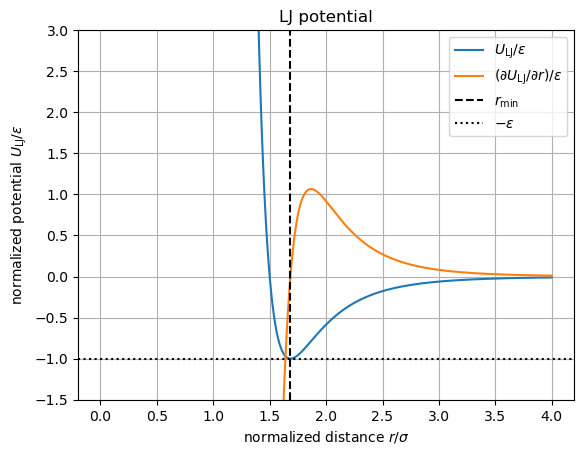

In [5]:
with torch.no_grad():
    plt.plot(xs,ps,label="$U_\\mathrm{LJ}/\\varepsilon$")
    plt.plot(xs,dps,label="$(\\partial U_\\mathrm{LJ}/\\partial r)/\\varepsilon$")
plt.ylim(-1.5,3)
plt.grid(True)
plt.title("LJ potential")
plt.xlabel("normalized distance $r/\\sigma$")
plt.ylabel("normalized potential $U_\\mathrm{LJ}/\\varepsilon$")
r_min = (2 ** (1/6)) * sig
plt.axvline(r_min, color="k", linestyle="--", label="$r_\\mathrm{min}$")
plt.axhline(-eps, color="k", linestyle=":", label="$-\\varepsilon$")
plt.legend()

### Calculating forces

Calculate the force between two particles at positions $r_1$ and $r_2$ like this: $\text{F}=-\frac{\partial U_\text{LJ}}{\partial r}$ where $r$ is the euclidean distance between the two particles.

In [6]:
dt = 8e-7
epochs, subepochs = 50, 2000
total_epochs = epochs*subepochs
m = 1.0 # particle mass

In [7]:
r1 = torch.tensor([0.0,0.0], requires_grad=True)
v1 = torch.tensor([10.0*sig,0.0])
r2 = torch.tensor([1.0*sig,0.0], requires_grad=True)
v2 = torch.tensor([-10.0*sig,0.0])
(r1,v1,r2,v2)

(tensor([0., 0.], requires_grad=True),
 tensor([15.,  0.]),
 tensor([1.5000, 0.0000], requires_grad=True),
 tensor([-15.,   0.]))

In [8]:
K = lambda v: 0.5*m*(F.norm(v, p=2.0)**2)
Ks,Us = [K(v1)+K(v2)],[Ulj(F.norm(r1 - r2, p=2.0)).item()]
traj1,traj2 = (
    [(r1.detach().clone(),v1.detach().clone())],
    [(r2.detach().clone(),v2.detach().clone())],
)
dists=[F.norm(r1-r2,p=2.0).detach().item()]

In [ ]:
for epoch in tqdm(range(epochs)):
    for _ in range(subepochs):
        # calculate forces
        dist = F.norm(r1 - r2, p=2.0)
        pot = Ulj(dist)
        
        # clear gradients and calc derivative
        r1.grad = None
        r2.grad = None
        pot.backward()
        
        # update particles
        with torch.no_grad():
            F1,F2 = -r1.grad,-r2.grad
            a1,a2 = F1/m,F2/m

            # TODO: velocity verlet
            v1 += dt*a1
            v2 += dt*a2
            r1 += dt*v1# + 0.5*a1*(dt**2)
            r2 += dt*v2# + 0.5*a2*(dt**2)
    with torch.no_grad():
        traj1.append((r1.clone(),v1.clone()*dt))
        traj2.append((r2.clone(),v2.clone()*dt))
        Ks.append(K(v1) + K(v2))
        Us.append(pot.item())
        dists.append(dist.item())

 12%|████████▉                                                                 | 6/50 [00:01<00:14,  3.12it/s]

In [ ]:
# show hockeystick diagram
fig,(e_ax,d_ax) = plt.subplots(nrows=2,sharex=True,figsize=(5,5))
e_ax.plot(Ks, label="kinetic energy")
e_ax.plot(Us, label="potential energy")
e_ax.plot(torch.tensor(Ks)+torch.tensor(Us), label="total energy")
e_ax.legend()
d_ax.plot(dists, label="distance between particles")
d_ax.legend()

In [ ]:
arrow_params = lambda c: dict(head_width=0.05, head_length=0.1, fc=c, ec=c, animated=True)

fig,ax = plt.subplots(figsize=(6,6))

# plot organization
ax.set_title("world with two particles")
ax.grid(True)
ax.set_xlim(-1,3)
ax.set_ylim(-2,2)

# store trajectory images
frames = []
for (r1t,v1t),(r2t,v2t) in zip(traj1,traj2):
    frames.append([
        ax.scatter(*r1t, label="p1", color="r", animated=True),
        ax.arrow(*r1t, *v1t, label="p1's speed vector", **arrow_params("r")),
        ax.scatter(*r2t, label="p2", color="b", animated=True),
        ax.arrow(*r2t, *v2t, label="p2's speed vector", **arrow_params("b")),
    ])
ani = animation.ArtistAnimation(fig, frames, interval=100, blit=True, repeat_delay=1500)
HTML(ani.to_html5_video())